In [1]:
import pandas as pd

In [4]:
df = pd.read_csv('arabic_f.csv')
df

,y,text
0,0,بيونسيه تتضاعف لأول مرة أغنية أخرى لاستدراج عر...
1,1,مرض ماكين يحرم مجلس شيوخ تصويت حاسم اشنطن رويت...
2,0,تقرير تقول جماعات حقوق مدنية قمع ناخبين مسؤول ...
3,0,يروي عامل ديزني قصة مرعبة إجباره تدريب عامل أج...
4,1,بيت أبيض اشنطن رويترز قال بيت أبيض يوم ترامب ب...
...,...,...
42417,1,زير مالية ألماني فولفغانغ شيوبله يحذر ترامب حم...
42418,1,بورتو أورداز فنزويلا رويترز قالت سلطات فنزويلي...
42419,0,تمكن مكتب تحقيقات فيدرالي كشف مؤامرة إرهابية ي...
42420,1,خطة ضريبية تهدد منطقة برمودا ول ستريت نيويورك ...


In [9]:
df = df.dropna(subset=['text'])
print(df.isnull().sum())

y       0
text    0
dtype: int64


In [11]:
from sklearn.model_selection import train_test_split

# df يحتوي عمود 'text' و 'label'
X = df['text']
y = df['y']

# 70% Train, 30% Temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y)

# 15% Validation, 15% Test (نصف 30%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print("Train:", len(X_train))
print("Validation:", len(X_val))
print("Test:", len(X_test))


Train: 29665
Validation: 6357
Test: 6357


# finished the part of the splite
## the next is the part of **TF-IDF** :

In [12]:
import re

def arabic_tokenizer(text):
    # الاحتفاظ بالحروف العربية فقط + الأعداد إذا أردت
    text = re.sub(r"[^ء-ي\s]+", " ", text)

    # حذف المسافات المتكررة
    text = re.sub(r"\s+", " ", text).strip()

    # تحويل النص إلى قائمة كلمات
    tokens = text.split()
    return tokens


from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    tokenizer=arabic_tokenizer,
    ngram_range=(1, 2),      # Unigrams + Bigrams
    max_features=7000,       # يمكن تغييره
    min_df=3,
    max_df=0.9,
    sublinear_tf=True,
    lowercase=False          # مهم جداً لأن tokenizer يعتني بالأحرف
)

tfidf.fit(X_train)

X_train_tfidf = tfidf.transform(X_train)
X_val_tfidf   = tfidf.transform(X_val)
X_test_tfidf  = tfidf.transform(X_test)


C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [13]:
fake_keywords = [
    "عاجل", "فضيحة", "كارثة", "تحذير", "خطير", "هام", "حصري",
    "لن تصدق", "شاهد", "صادم", "كشف", "تسريب", "خطير جدا"
]


In [14]:
import numpy as np
import string

def extract_linguistic_features(text):
    text = str(text)
    
    length = len(text)
    words = arabic_tokenizer(text)
    word_count = len(words)

    # علامات الترقيم
    punct_count = sum(1 for c in text if c in string.punctuation)
    punctuation_ratio = punct_count / (length + 1)

    # علامة التعجب
    exclamation_ratio = text.count("!") / (length + 1)

    # كلمات مثيرة (Fake-News Keywords)
    keyword_flag = any(kw in text for kw in fake_keywords)

    return [
        length,
        word_count,
        punctuation_ratio,
        exclamation_ratio,
        int(keyword_flag)
    ]


In [15]:
def build_linguistic_matrix(series):
    return np.array([extract_linguistic_features(t) for t in series])

X_train_ling = build_linguistic_matrix(X_train)
X_val_ling   = build_linguistic_matrix(X_val)
X_test_ling  = build_linguistic_matrix(X_test)


In [17]:
from textblob import TextBlob

def get_sentiment(text):
    polarity = TextBlob(str(text)).sentiment.polarity

    if polarity > 0.1:
        return [1, 0, 0]  # Positive
    elif polarity < -0.1:
        return [0, 0, 1]  # Negative
    else:
        return [0, 1, 0]  # Neutral


In [18]:
X_train_sent = np.array([get_sentiment(t) for t in X_train])
X_val_sent   = np.array([get_sentiment(t) for t in X_val])
X_test_sent  = np.array([get_sentiment(t) for t in X_test])


In [19]:
from scipy.sparse import hstack

X_train_full = hstack([X_train_tfidf, X_train_ling, X_train_sent])
X_val_full   = hstack([X_val_tfidf,   X_val_ling,   X_val_sent])
X_test_full  = hstack([X_test_tfidf,  X_test_ling,  X_test_sent])


In [20]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from scipy.sparse import hstack


In [21]:
# class_weight='balanced' للتعامل مع عدم التوازن
model_lr = LogisticRegression(
    max_iter=300,
    class_weight='balanced',  
    solver='liblinear',         # جيد للنماذج صغيرة/متوسطة الحجم
    random_state=42
)


In [22]:
model_lr.fit(X_train_full, y_train)


LogisticRegression(class_weight='balanced', max_iter=300, random_state=42,
                   solver='liblinear')

Validation Accuracy: 0.9859996853861884
Validation F1-score: 0.9859994511859498

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      3176
           1       0.98      0.99      0.99      3181

    accuracy                           0.99      6357
   macro avg       0.99      0.99      0.99      6357
weighted avg       0.99      0.99      0.99      6357



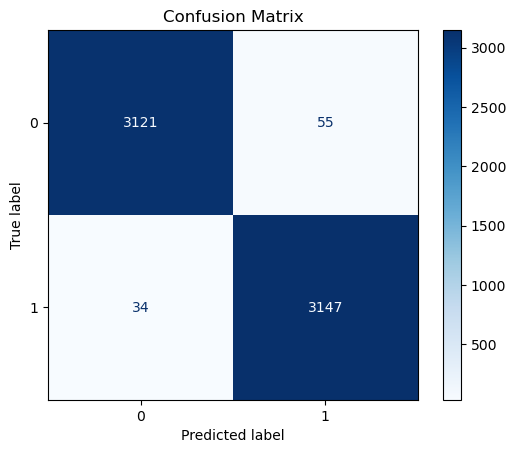

In [26]:
y_val_pred = model_lr.predict(X_val_full)

print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation F1-score:", f1_score(y_val, y_val_pred, average='macro'))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))




In [24]:
y_test_pred = model_lr.predict(X_test_full)

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test F1-score:", f1_score(y_test, y_test_pred, average='macro'))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))


Test Accuracy: 0.9877300613496932
Test F1-score: 0.9877299007298028

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      3177
           1       0.98      0.99      0.99      3180

    accuracy                           0.99      6357
   macro avg       0.99      0.99      0.99      6357
weighted avg       0.99      0.99      0.99      6357



# =============================================================================
# =============================================================================

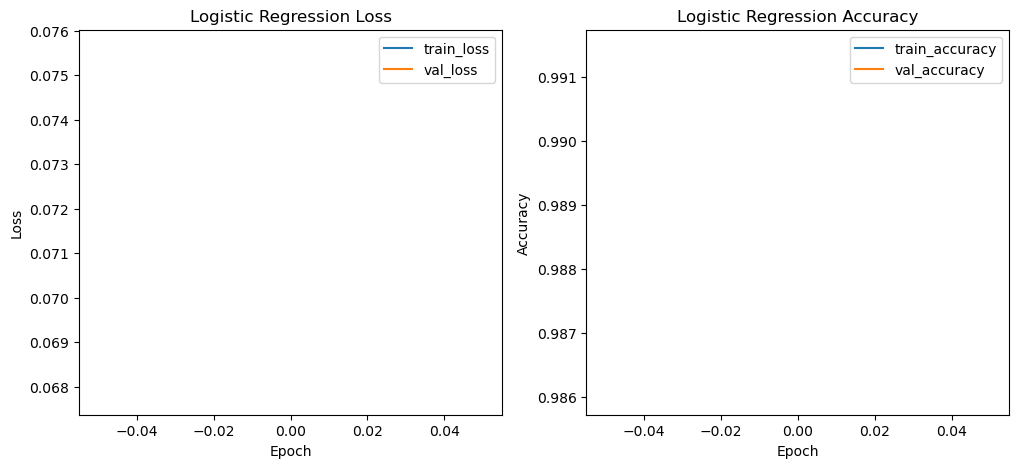

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
import numpy as np

epochs = 20
train_loss = []
val_loss = []
train_acc = []
val_acc = []

for epoch in range(epochs):
    model_lr.fit(X_train_full, y_train)

y_train_pred_prob = model_lr.predict_proba(X_train_full)
y_val_pred_prob   = model_lr.predict_proba(X_val_full)
    
    # حساب loss
train_loss.append(log_loss(y_train, y_train_pred_prob))
val_loss.append(log_loss(y_val, y_val_pred_prob))
    
    # حساب accuracy
train_acc.append(accuracy_score(y_train, model_lr.predict(X_train_full)))
val_acc.append(accuracy_score(y_val, model_lr.predict(X_val_full)))

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.title('Logistic Regression Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc, label='train_accuracy')
plt.plot(val_acc, label='val_accuracy')
plt.title('Logistic Regression Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()




## ========================================

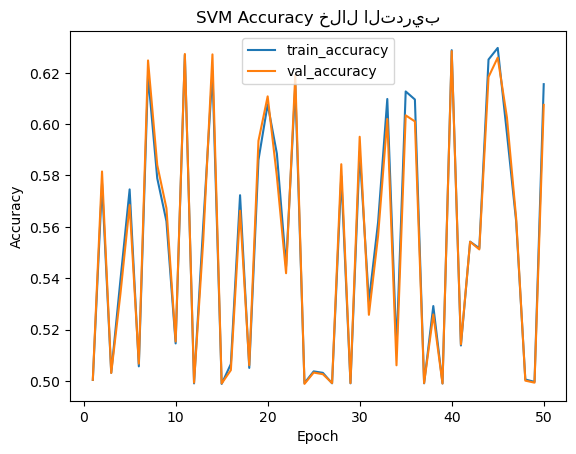

In [77]:
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# تحويل إلى CSR إذا كانت COO
if hasattr(X_train_full, "tocsc"):  # أي نوع sparse لديه tocsc/tocsr
    X_train_np = X_train_full.tocsr()
    X_val_np = X_val_full.tocsr()
else:
    X_train_np = X_train_full
    X_val_np = X_val_full

# تحويل y إلى numpy
y_train_np = y_train.values.ravel() if hasattr(y_train, "values") else y_train
y_val_np = y_val.values.ravel() if hasattr(y_val, "values") else y_val

# نموذج SVM باستخدام SGD
model_svm = SGDClassifier(loss='perceptron', learning_rate='optimal')

epochs = 50
batch_size = 1
train_acc = []
val_acc = []

classes = np.unique(y_train_np)
n_samples = X_train_np.shape[0]

for epoch in range(epochs):
    indices = np.random.permutation(n_samples)
    X_train_shuffled = X_train_np[indices]
    y_train_shuffled = y_train_np[indices]
    
    for start in range(0, n_samples, batch_size):
        end = start + batch_size
        X_batch = X_train_shuffled[start:end]
        y_batch = y_train_shuffled[start:end]
        
        if epoch == 0 and start == 0:
            model_svm.partial_fit(X_batch, y_batch, classes=classes)
        else:
            model_svm.partial_fit(X_batch, y_batch)
    
    train_acc.append(accuracy_score(y_train_np, model_svm.predict(X_train_np)))
    val_acc.append(accuracy_score(y_val_np, model_svm.predict(X_val_np)))

plt.plot(range(1, epochs+1), train_acc, label='train_accuracy')
plt.plot(range(1, epochs+1), val_acc, label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('SVM Accuracy خلال التدريب')
plt.legend()
plt.show()


In [78]:
y_test_pred = model_svm.predict(X_test_full)

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test F1-score:", f1_score(y_test, y_test_pred, average='macro'))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))


Test Accuracy: 0.6174296051596665
Test F1-score: 0.6105484325632817

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.75      0.66      3177
           1       0.66      0.48      0.56      3180

    accuracy                           0.62      6357
   macro avg       0.63      0.62      0.61      6357
weighted avg       0.63      0.62      0.61      6357

